# Inertial Waves Analytic Solutions

The inertial waves problem is given by
\begin{align}
i \lambda \vec{u} + 2 \vec{e}_z \times \vec{u} &= -\nabla p \\
\nabla \cdot \vec{u} &= 0
\end{align}
with $\vec{e}_r \cdot \vec{u} = 0$ at $r = 1$.

The pressure is then given by
\begin{align}
\lambda^2 \nabla^2 p - 4 \partial_z^2 p = 0.
\end{align}

Greenspan demonstrates inertial waves in the sphere are separable in the oblate spheroidal
coordinates
\begin{align}
r &= \left( \frac{4}{4-\lambda^2} - \eta^2 \right)^\frac{1}{2} \left(1 - \mu^2 \right)^\frac{1}{2} \\
z &= \left( \frac{4}{\lambda^2} - 1 \right)^\frac{1}{2} \eta \mu
\end{align}
such that the pressure satisfies
\begin{align}
P_{nkm} = \Psi_{nkm}(r,z) e^{i m \phi} = P_n^{|m|} \left( \eta/c_{nkm} \right) P_n^{|m|}(\mu) e^{i m \phi}
\end{align}
where
$$ c_{nkm} = \left( 1 - \frac{1}{4} \lambda_{nkm}^2 \right)^{-\frac{1}{2}} $$
and $\lambda_{nkm}$ is the $k$th eigenvalue solution of
\begin{align}
m P_n^{|m|}(z) = (1-z^2) \frac{d}{dz} P_n^{|m|}(z).
\end{align}

Note that the associated Legendre functions are given by
$$ P_n^{|m|}(z) = \left(1 - z^2 \right)^{\frac{m}{2}} P_{n-|m|}^{|m|,|m|}(z) $$
hence we find the roots of
\begin{align}
m (1+z) P_{n-|m|}^{|m|,|m|}(z) = (1-z^2) \frac{d}{dz} P_{n-|m|}^{|m|,|m|}(z).
\end{align}

In [1]:
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=4,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from eigtools import eigsort
from greenspan_inertial_waves import compute_eigenvalues, associated_legendre_nodes, compute_eigenmode


# Jacobi operators
A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
D = Jacobi.operator('D')
Z = Jacobi.operator('Z')
Id = Jacobi.operator('Id')


In [3]:
def plotfield(s, z, f, zoombox=None):
    fig, ax = plt.subplots(figsize=(4.25,6))
    im = ax.pcolormesh(s, z, f, cmap='RdBu')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('s')
    ax.set_ylabel('z')
    if zoombox is None:
        ax.set_aspect('equal', adjustable='box')
    else:
        ax.set_xlim(zoombox[0])
        ax.set_ylim(zoombox[1])
    fig.set_tight_layout(True)



1.9151347174783950322e-15


<IPython.core.display.Javascript object>


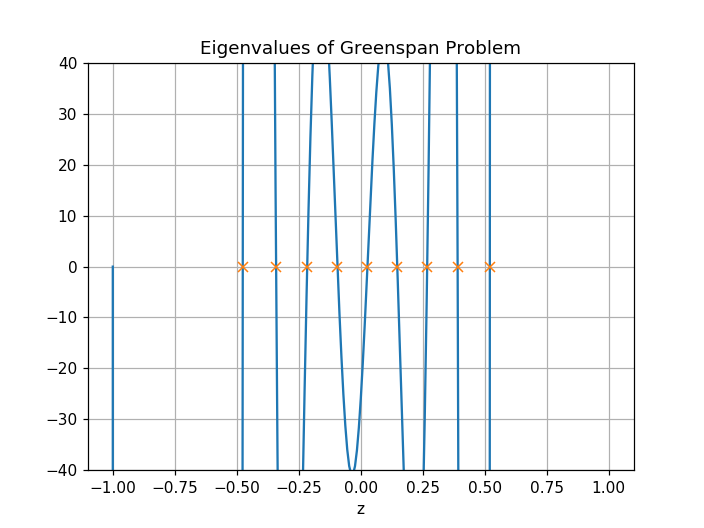

In [78]:
n, m = 40, 31
nroots = n-m

nz = 257
z = np.linspace(-1,1,nz)

op = operator(m)
Pn = Jacobi.polynomials(n+2,m,m,z).T
f = (Pn @ op(n+1,m,m))[:,n-m]

xi = compute_eigenvalues(n, m)
assert len(xi) == nroots

Pni = Jacobi.polynomials(n+2,m,m,xi,dtype='float128').T
fi = (Pni @ op(n+1,m,m))[:,n-m]
print(np.max(np.abs(fi)))
assert np.max(np.abs(fi)) < 6e-6

plt.figure()
plt.plot(z, f)
plt.plot(xi,fi,'x')
plt.xlabel('z')
plt.ylim([-40,40])
plt.title('Eigenvalues of Greenspan Problem')
plt.grid()


<IPython.core.display.Javascript object>


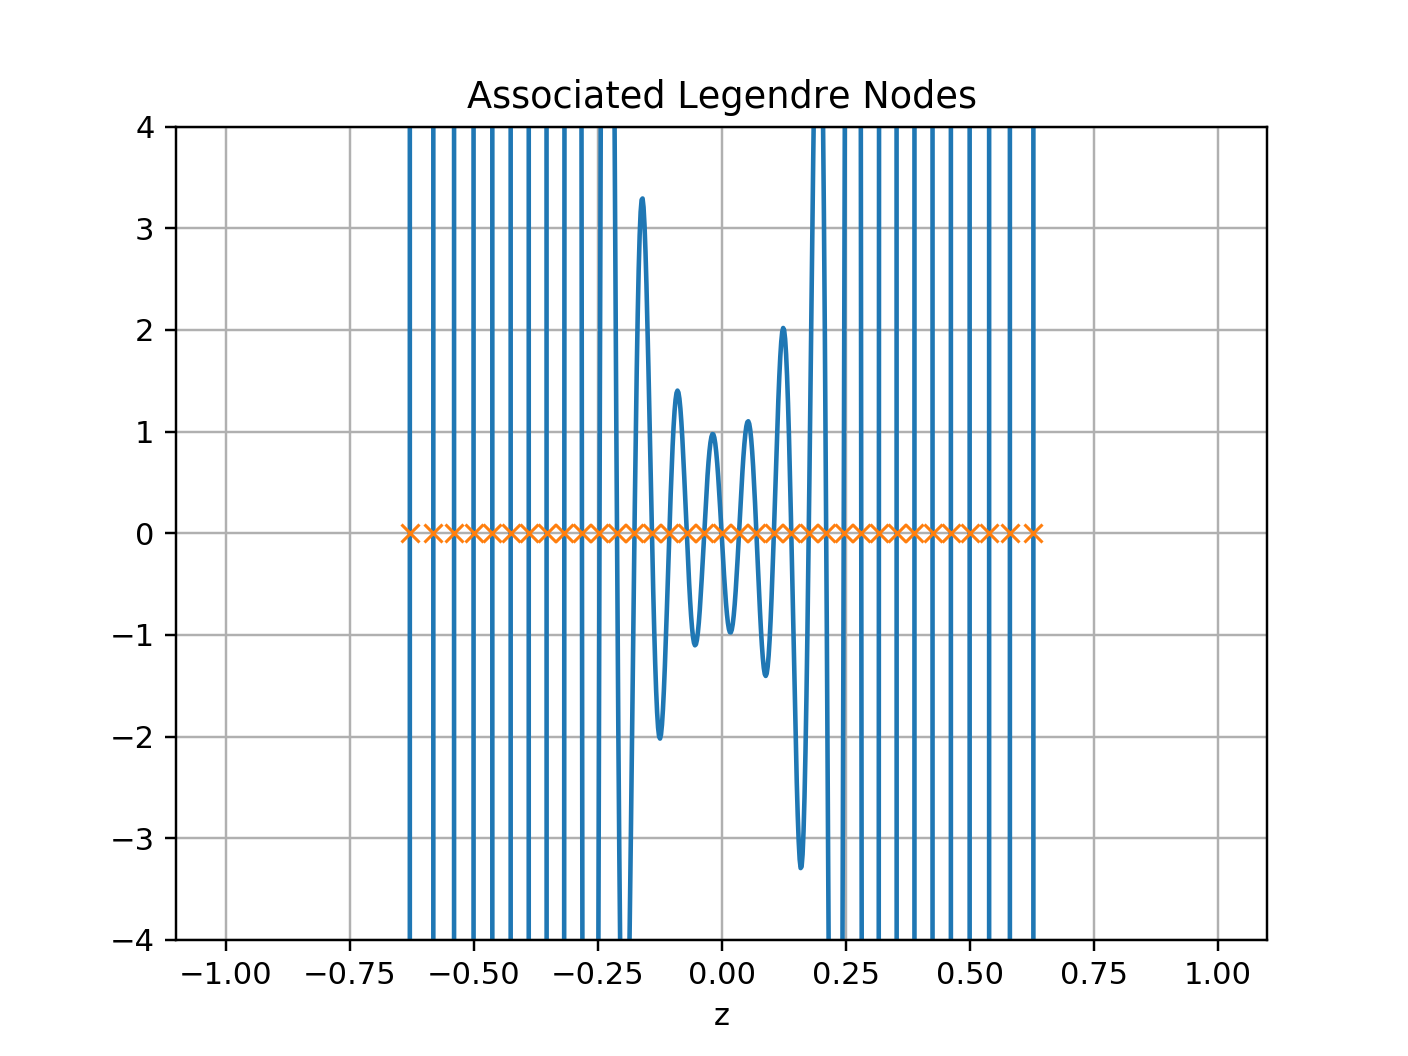

In [82]:
n, m = 130, 95

nz = 1024
z = np.linspace(-1,1,nz)

Pn = Jacobi.polynomials(n-m+1,m,m,z).T[:,n-m]
zi = associated_legendre_nodes(n, m, maxiter=12)

fi = Jacobi.polynomials(n-m+1,m,m,zi).T[:,n-m]
assert len(zi) == n-m
assert np.max(np.abs(fi)) < 2e-8

plt.figure()
plt.plot(z, Pn)
plt.plot(zi,fi,'x')
plt.xlabel('z')
plt.ylim([-4,4])
plt.title('Associated Legendre Nodes')
plt.grid()


Greenspan Eigenvalue for mode (40,1,30): -1.024993


<IPython.core.display.Javascript object>


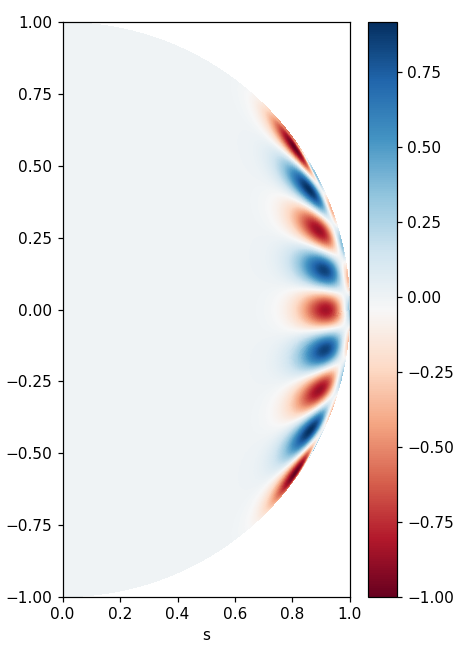

In [265]:
ns, neta = 1000, 1001
s = np.linspace(0,1,1000).reshape((1,ns))
eta = np.linspace(-1,1,1001).reshape((neta,1))
z = eta*np.sqrt(1-s**2)

n, k, m = 40, 1, 30
f = compute_mode(s,z,n,k,m)
plotfield(s, z, f)


In [254]:
n, m = 6,2

# Compute the eigenvalue
roots = compute_eigenvalues(n, m)
for k in range(len(roots)):
    mu = roots[k]
    print('modes[({},{},{})] = {:1.6f}'.format(n,k+1,m,2*mu))


modes[(6,1,2)] = -1.092568
modes[(6,2,2)] = -0.101790
modes[(6,3,2)] = 0.884249
modes[(6,4,2)] = 1.643443


In [239]:
def normalize(f, axis=0):
    norm = np.max(np.abs(f), axis=axis, keepdims=True)
    norm = np.where(norm == 0, 1, norm)
    return f/norm

In [262]:
Lmax, m, n = 10, 1, 4
domain = (Lmax,0,0)

nz = 250
z = np.linspace(-1,1,nz).reshape(nz,1)

# Compute the Legendre functions for Jacobi polynomials
op = D(+1)**m
codomain = op.codomain(*domain)
Pn = Jacobi.polynomials(*codomain, z.ravel()).T
legendre = ((-1)**m * (1-z**2)**(m/2) * Pn @ op(*domain))

# Compute the Legendre functions from monomial expressions
x = z.ravel()
nexact = 5
exact = np.zeros((5,nz,nexact))
exact[1,:,1] = -(1-x**2)**(1/2)
exact[1,:,2] = -3*x*(1-x**2)**(1/2)
exact[1,:,3] = -3/2*(5*x**2-1)*(1-x**2)**(1/2)
exact[1,:,4] = -5/2*(7*x**3-3*x)*(1-x**2)**(1/2)
exact[2,:,2] = 3*(1-x**2)
exact[2,:,3] = 15*x*(1-x**2)
exact[2,:,4] = 15/2*(7*x**2-1)*(1-x**2)
exact[3,:,3] = -15*(1-x**2)**(3/2)
exact[3,:,4] = -105*x*(1-x**2)**(3/2)
exact[4,:,4] = 105*(1-x**2)**2

exact = normalize(exact, axis=1)
legendre = normalize(legendre)
assert np.max(np.abs(exact[m,:,:] - legendre[:,:nexact])) < 1e-15

# Compute the Legendre functions from products of roots
if n > m+1:
    nodes = associated_legendre_nodes(n, m)
    nodes = nodes[nodes>=1e-6]
else:
    nodes = []
nu = (n-m) % 2
legendre2 = (-1)**m * x**nu * (1-x**2)**(m/2) * np.prod([x**2 - xj**2 for xj in nodes], axis=0)
legendre2 = normalize(legendre2)
assert np.max(np.abs(legendre2-exact[m,:,n])) < 1e-15
